In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [13]:
# 1.set stocks tickets
tickers = ['ARM', 'APLE','NVDA']
n_assets = len(tickers)

In [3]:
# 2.set date
start_date = '2024-04-01'
end_date = '2025-11-23'

In [14]:
# 3.download the data
data = yf.download(tickers, start=start_date, end=end_date, auto_adjust=False)['Adj Close']
data.head()

[*********************100%***********************]  3 of 3 completed


Ticker,APLE,ARM,NVDA
Date,,,
2024-04-01,14.535616,126.910004,90.321945
2024-04-02,14.482143,124.279999,89.411362
2024-04-03,14.303899,125.309998,88.923592
2024-04-04,14.250430,122.010002,85.865967
2024-04-05,14.312812,124.820000,87.968025


In [15]:
# 4.drop Nan value
data = data.dropna()
print(f"successfully get {len(data)} transaction days。")

successfully get 415 transaction days。


In [16]:
# 5.calculate daily return using pct_change
returns = data.pct_change().dropna()
returns.head()

Ticker,APLE,ARM,NVDA
Date,,,
2024-04-02,-0.003679,-0.020723,-0.010082
2024-04-03,-0.012308,0.008288,-0.005455
2024-04-04,-0.003738,-0.026335,-0.034385
2024-04-05,0.004378,0.023031,0.024481
2024-04-08,0.009340,0.035491,-0.009942


In [17]:
# 6.Calculate Key Matrices (Mapping to Handout 1)
# 6.1 Expected Return Vector mu (Annualized)
# We assume 252 trading days in a year
mu_daily = returns.mean()
mu_annual = mu_daily * 252
mu_annual

Ticker
APLE   -0.093919
ARM     0.236533
NVDA    0.551729
dtype: float64

In [18]:
# 6.2 Covariance Matrix Sigma (Annualized)
Sigma_daily = returns.cov()
Sigma_annual = Sigma_daily * 252
Sigma_annual

Ticker,APLE,ARM,NVDA
Ticker,,,
APLE,0.072014,0.058407,0.034809
ARM,0.058407,0.430831,0.231060
NVDA,0.034809,0.231060,0.270983


In [19]:
# 7. optimization Model Setup

# Objective Function
# min -t*mu'x + 0.5*x'Sigma*x
def objective_function(weights, mu, Sigma, t):
    # Expected Return term (Negative for minimization)
    term1 = -t * np.dot(weights, mu)
    # Variance term (Risk)
    term2 = 0.5 * np.dot(weights.T, np.dot(Sigma, weights))
    return term1 + term2

# Constraints
# 7.1. Budget Constraint: sum(x) = 1
def constraint_sum(weights):
    return np.sum(weights) - 1

# 7.2. Bound Constraints: x >= 0 (No short selling)
# Range for each weight is [0, 1]
bounds = tuple((0, 1) for _ in range(n_assets))

# Constraint dictionary format for scipy
constraints = ({'type': 'eq', 'fun': constraint_sum})

In [20]:
# 8. Tracing the Efficient Frontier
# We scan different risk tolerance parameters 't' from 0 to 2.0
# t=0 corresponds to the Global Minimum Variance Portfolio
t_values = np.linspace(0, 2.0, 50) 

# 2025 NOV risk_free rate
rf = 0.04 


frontier_returns = []
frontier_volatility = []
sharpe_ratios = []
all_weights = []

print("Running Parametric Quadratic Programming optimization...")

for t in t_values:
    # Initial guess (Equal weights)
    init_guess = n_assets * [1. / n_assets,]
    
    # Arguments for the objective function
    args = (mu_annual, Sigma_annual, t)
    
    # Run Optimizer SLSQP
    result = minimize(objective_function, init_guess, args=args,
                      method='SLSQP', bounds=bounds, constraints=constraints)
    
    if result.success:
        # Extract optimal weights
        w = result.x
        all_weights.append(w)
        
        # Calculate annualized metrics for this portfolio
        # mu_p = mu'x
        ret = np.dot(w, mu_annual)
        # sigma_p^2 = x'Sigma x => volatility is sqrt
        vol = np.sqrt(np.dot(w.T, np.dot(Sigma_annual, w)))
        
        frontier_returns.append(ret)
        frontier_volatility.append(vol)
        
        # Calculate Sharpe Ratio
        # SR = (mu_p - rf) / sigma_p
        sr = (ret - rf) / vol
        sharpe_ratios.append(sr)

Running Parametric Quadratic Programming optimization...


In [25]:
# 9. Selecting the Optimal Portfolio
# Find the index with the maximum Sharpe Ratio
max_sr_idx = np.argmax(sharpe_ratios)

# Retrieve data for the optimal portfolio
optimal_weights = all_weights[max_sr_idx]
opt_ret = frontier_returns[max_sr_idx]
opt_vol = frontier_volatility[max_sr_idx]
best_t = t_values[max_sr_idx]

print("\n" + "="*40)
print(f"Optimization Complete! (Based on Max Sharpe, t={best_t:.2f})")
print("="*40)
print(f"Expected Annual Return:    {optimal_ret:.2%}")
print(f"Expected Annual Volatility:{optimal_vol:.2%}")
print(f"Maximum Sharpe Ratio:      {sharpe_ratios[max_sr_idx]:.2f}")
print("-" * 40)
print("Optimal Weights Allocation:")
for ticker, weight in zip(tickers, optimal_weights):
    print(f"  {ticker}: {weight:.2%}")
print("="*40)


Optimization Complete! (Based on Max Sharpe, t=0.41)
Expected Annual Return:    55.17%
Expected Annual Volatility:52.06%
Maximum Sharpe Ratio:      0.98
----------------------------------------
Optimal Weights Allocation:
  ARM: 0.00%
  APLE: 0.00%
  NVDA: 100.00%


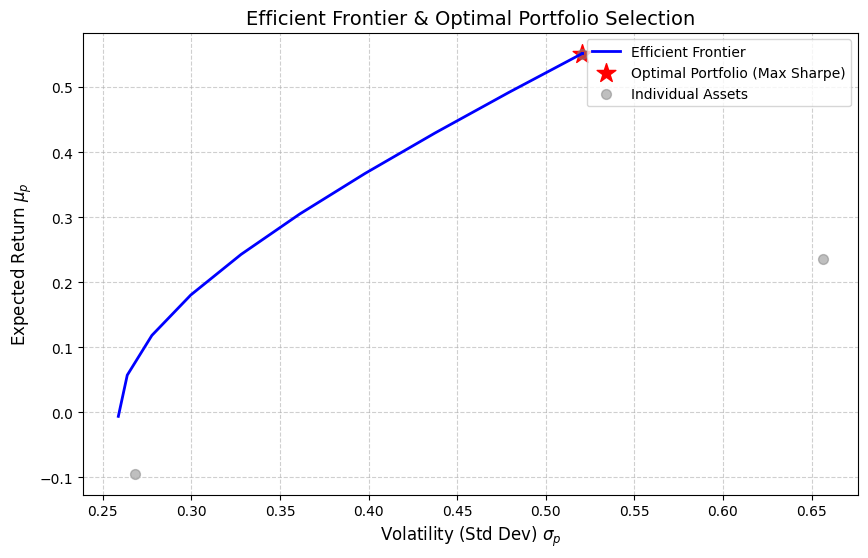

In [26]:
# 10. Visualization (Efficient Frontier)
plt.figure(figsize=(10, 6))

# Plot Efficient Frontier
plt.plot(frontier_volatility, frontier_returns, 'b-', linewidth=2, label='Efficient Frontier')

# Plot Optimal Portfolio
plt.scatter(opt_vol, opt_ret, c='red', s=200, marker='*', label='Optimal Portfolio (Max Sharpe)')

# Plot Individual Assets
asset_vols = np.sqrt(np.diag(Sigma_annual))
asset_rets = mu_annual
plt.scatter(asset_vols, asset_rets, c='gray', s=50, alpha=0.5, label='Individual Assets')

plt.title('Efficient Frontier & Optimal Portfolio Selection', fontsize=14)


plt.xlabel(r'Volatility (Std Dev) $\sigma_p$', fontsize=12)
plt.ylabel(r'Expected Return $\mu_p$', fontsize=12)

plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()